In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

interim = Path('../data/interim')
processed = Path('../data/processed')
events = pd.read_pickle(Path(interim) / 'events.pkl')
game_logs = pd.read_pickle(Path(interim) / 'game_logs.pkl')

In [2]:
base = game_logs.loc[:, ['GAME_ID', 'HomeTeam', 'VisitingTeam', 'ParkID', 'HomeH', 'VisitorH']]
base['year'] = base['GAME_ID'].str.slice(3, 7)

In [3]:
Home = base.groupby(['HomeTeam', 'year', 'ParkID']).agg({'HomeH':'sum', 'VisitorH':'sum', 'GAME_ID':'nunique'})
Home.columns = ['home_hs', 'home_ha', 'home_g']
Home['home_factor'] = (Home['home_hs'] + Home['home_ha']) / Home['home_g']
Home = Home.rename_axis(['team', 'year', 'ParkID'])

In [4]:
Road = base.groupby(['VisitingTeam', 'year']).agg({'HomeH':'sum', 'VisitorH':'sum', 'GAME_ID':'nunique'})
Road.columns = ['road_ha', 'road_hs', 'road_g']
Road['road_factor'] = (Road['road_hs'] + Road['road_ha']) / Road['road_g']
Road = Road.rename_axis(['team', 'year'])

In [5]:
park_factors = pd.merge(Home, Road, left_index=True, right_index=True)
park_factors['factor'] = (park_factors['home_factor'] / park_factors['road_factor']).astype('float')
park_factors = park_factors.reset_index().set_index(['ParkID', 'year'])
park_factors = park_factors.sort_values(['team', 'year'])
# park_factors.loc[park_factors['factor'] > 1.3, 'factor'] = np.NaN
# park_factors.loc[park_factors['factor'] < .8, 'factor'] = np.NaN
park_factors['lag_factor'] = park_factors.groupby('ParkID')['factor'].shift(1)

In [6]:
result = sm.ols(formula="factor ~ lag_factor", data=park_factors).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     581.8
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          4.92e-116
Time:                        13:02:50   Log-Likelihood:                 3096.6
No. Observations:                2571   AIC:                            -6189.
Df Residuals:                    2569   BIC:                            -6178.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5779      0.018     32.875      0.0

<AxesSubplot:xlabel='lag_factor', ylabel='factor'>

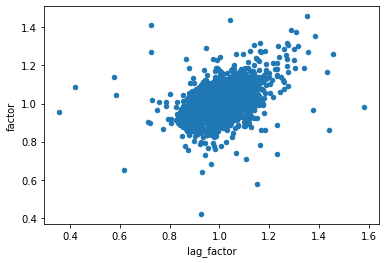

In [7]:
park_factors.plot.scatter(x='lag_factor', y='factor')

<AxesSubplot:>

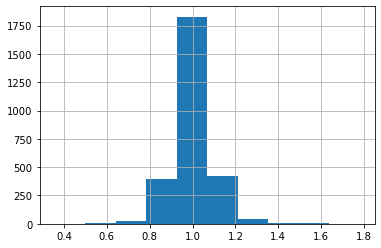

In [8]:
park_factors['factor'].hist()